# Computer vision 
## Assignment 4
### Benjamin Wild

In [1]:
from collections import OrderedDict
import io as ioo
import base64
import math

import numpy as np
from skimage import io

import scipy

import imageio

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.draw import line
from skimage.morphology import square, dilation
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_borderaa
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops

import PIL

from IPython.display import HTML

%matplotlib inline

# Aufgabe 2: Hu-Momente

In [2]:
image_needle = io.imread('needle.png')
image_heystack = io.imread('heystack.png')

In [3]:
def raw_moment(image, iord, jord):
    if iord == 0 and jord == 0:
        return image.sum()
    nrows, ncols = image.shape
    y, x = np.mgrid[:nrows, :ncols]
    image = image * x**iord * y**jord
    return image.sum()
    
    
def mu_moment(image, x_bar, y_bar, i, j):
    m = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            m += (x - x_bar)**i * (y - y_bar)**j * image[y, x]
    return m


def calc_eta(mu_ij, mu_zero, i, j):
    return mu_ij / mu_zero**(1. + (i+j)/2)
           

def hu_moments(image):
    mus = {}
    etas = {}
    def mu(i , j):
        if (i , j) not in mus:
            mus[(i , j)] = mu_moment(image, x_bar, y_bar, i, j)
        return mus[(i , j)]
    raw_00 = raw_moment(image, 0, 0)
    x_bar = raw_moment(image, 1, 0) / raw_00
    y_bar = raw_moment(image, 0, 1) / raw_00
    def eta(i, j):
        if (i, j) not in etas:
            mu_ij =  mu(i, j)
            mu_zero = mu(0, 0)
            etas[(i , j)] = calc_eta(mu_ij, mu_zero, i, j)
        return etas[(i, j)]
    
    
    moments = np.zeros((7, ))                         
           
    moments[0] = eta(2, 0) + eta(0, 2)
    moments[1] = (eta(2, 0) - eta(0, 2))**2 + 4 * eta(1, 11) ** 2
    moments[2] = (eta(3, 0) - 3 * eta(1, 2))**2 + (3 * eta(2, 1) - eta(0, 3))**2
    moments[3] = (eta(3, 0) + eta(1, 2))**2 + (eta(2, 1) + eta(0, 3))**2
    moments[4] = (eta(3, 0) - 3 * eta(1, 2)) * (eta(3, 0) + eta(1, 2)) * ((eta(3, 0) + eta(1, 2))**2 - 3 * (eta(2, 1) + eta(0, 3))**2) + (3 *  eta(2, 1) - eta(0, 3)) * (eta(2, 1) + eta(0, 3)) * ( 3 * (eta(3, 0) + eta(1, 2))**2 - (eta(2, 1) + eta(0, 3))**2)
    moments[5] =  (eta(2, 0) - eta(0, 2)) * ((eta(3, 0) + eta(1, 2))**2 - (eta(2, 1) + eta(0, 3))**2) + 4 * eta(1, 1) * (eta(3, 0) + eta(1, 2)) * (eta(2, 1) + eta(0, 3))
    moments[6] = (3 * eta(2, 1) - eta(0, 3)) * (eta(3, 0) + eta(1, 2)) * ((eta(3, 0) + eta(1, 2))**2 - 3 * (eta(2, 1) + eta(0, 3))**2) - (eta(3, 0) - 3 * eta(1, 2)) * (eta(2, 1) + eta(0, 3)) * (3 * (eta(3, 0) + eta(1, 2))**2 - (eta(2, 1) + eta(0, 3))**2)
    
    return moments

In [4]:
def get_bounding_boxes(image):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = -1
    
    return label_image

In [5]:
def get_largest_bounding_box(image):
    label_image = get_bounding_boxes(image)
    
    regions = regionprops(label_image)
    regions = sorted(regions,reverse=True, key=lambda x: x.area)
    
    return regions[0] 

In [6]:
def draw_bounding_box_(minr, minc, maxr, maxc, ax):
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)    

def draw_bounding_box(region, ax):
    minr, minc, maxr, maxc = region.bbox
    draw_bounding_box_(minr, minc, maxr, maxc, ax)

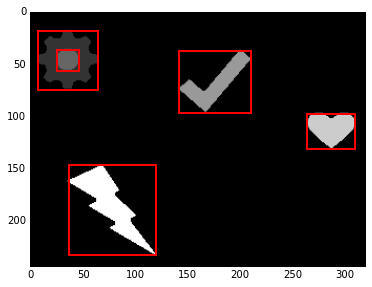

In [7]:
label_image = get_bounding_boxes(image_heystack)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(label_image, cmap=plt.cm.gray)

for region in regionprops(label_image):
    draw_bounding_box(region, ax)

In [ ]:
needle_moments = hu_moments(image_needle)
print(needle_moments)

subimages_by_distance = OrderedDict()

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    
    subimage = image_heystack[minr:maxr, minc:maxc]
    
    subimage_moments = hu_moments(subimage)
    print(subimage_moments)
    
    distance = np.linalg.norm(needle_moments - subimage_moments)
    print(distance)
    
    subimages_by_distance[distance] = subimage
    
    plt.figure()
    plt.imshow(subimage, cmap=plt.cm.gray)
    plt.show()

In [9]:
smallest_distance, found_subimage = next((iter(sorted(subimages_by_distance.items()))))


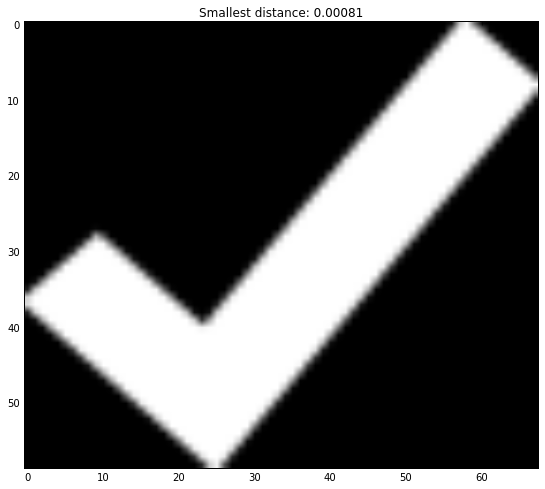

In [10]:
plt.figure(figsize=(16, 8))
plt.imshow(found_subimage, cmap=plt.cm.gray)
_ = plt.title('Smallest distance: {0:.5f}'.format(smallest_distance))

# Aufgabe 1: CAMSHIFT

In [11]:
class RGB2InputTransformer(object):
    
    def __init__(self, saturation_threshold = 50, median_filter = 20):
        self.saturation_threshold = saturation_threshold
        self.median_filter = median_filter
        
    def transform(self, image):
        image_hsv = matplotlib.colors.rgb_to_hsv(image)
        image_h = (image_hsv[:,:,0] * 255.0).astype(np.int32)

        image_s = (image_hsv[:,:,1] * 255.0).astype(np.int32)
        image_mask = np.zeros(image_s.shape)
        image_mask[image_s > self.saturation_threshold] = 1.0
        image_mask = scipy.ndimage.filters.median_filter(image_mask, size=self.median_filter)
        #image_h_masked = np.multiply(sample_h, image_mask)
        return image_h, image_mask
    
class HistogramClassifier(object):
    def fit(self, image, mask):
        self.mask = mask
        self.probability_distribution = np.zeros((256,))
        mask_flattened = mask.flatten()
        for index, value in enumerate(image.flatten()):
            if mask_flattened[index] <= 0.5: continue
            self.probability_distribution[value] += 1
        self.probability_distribution /= np.max(self.probability_distribution)
        
    def predict(self, image, mask):
        def assign_proba(value):
            return self.probability_distribution[int(value)]
        def assign_proba_xy(x, y, img, mask):
            if mask[y, x] < 0.5: return 0.0
            return assign_proba(img[y, x])

        proba_image = np.zeros(image.shape)
        for y in range(proba_image.shape[0]):
            for x in range(proba_image.shape[1]):
                proba_image[y, x] = assign_proba_xy(x, y, image, mask)
        return proba_image
            
class PreprocessingHistogrammClassifier(object):
    
    def __init__(self, **kwargs):
        self.preprocessing = RGB2InputTransformer(**kwargs)
        self.classifier    = HistogramClassifier()
        self.output_filter = kwargs["output_filter"] if "output_filter" in kwargs else 40
        
    @staticmethod
    def loadImage(path):
        return np.array(PIL.Image.open(path)).astype(np.float32) / 255.0
    
    def fit(self, image):
        image, mask = self.preprocessing.transform(image)
        self.classifier.fit(image, mask)
    
    def predict(self, image):
        image, mask = self.preprocessing.transform(image)
        predicted = self.classifier.predict(image, mask)
        filtered = scipy.ndimage.filters.median_filter(predicted, size=self.output_filter)
        return filtered

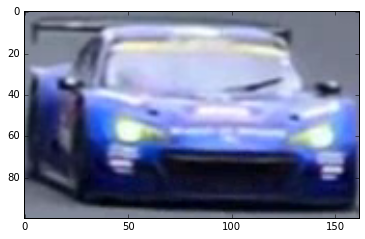

In [12]:
image = PreprocessingHistogrammClassifier.loadImage('racecar.png')
image = image[257:257+100, 480:480+162]
plt.imshow(image)

In [13]:
preprocessor = PreprocessingHistogrammClassifier(saturation_threshold=50)
preprocessor.fit(image)

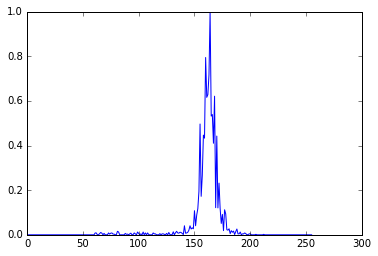

In [14]:
plt.plot(preprocessor.classifier.probability_distribution)

In [27]:
def meanshift_center(image, topleft):
    m_00 = raw_moment(image, 0, 0)
    m_10 = raw_moment(image, 1, 0)
    m_01 = raw_moment(image, 0, 1)
    return int(round(topleft[0] + m_01 / m_00)), int(round(topleft[1] + m_10 / m_00))

In [28]:
def camshift(image):
    m_00 = raw_moment(image, 0, 0)
    width = max(15, math.pi * math.sqrt(m_00))
    return int(round(width)), int(round(0.5 * width))

In [46]:
class Subimage:
    def __init__(self, image, subimage_bbox):
        self.image = image
        self.subimage_bbox = subimage_bbox
    def image_coor(self, point):
        return point[0] + subimage_bbox[0], point[1] + subimage_bbox[1]
    def width(self):
        minr, minc, maxr, maxc = self.subimage_bbox
        return maxc - minc
    def heigth(self):
        minr, minc, maxr, maxc = self.subimage_bbox
        return maxr - minr
    def center(self):
        minr, minc, maxr, maxc = self.subimage_bbox
        return (minr + maxr) // 2, (minc + maxc) // 2
    @staticmethod
    def restrict_range(x, r):
        return min(max(x, 0), r-1)
    
    def restrict_by_width(self, x):
        return self.restrict_range(x, self.image.shape[1])
    
    def restrict_by_height(self, x):
        return self.restrict_range(x, self.image.shape[0])

    def topleft(self, border=0):
        b = self.subimage_bbox
        return self.restrict_by_height(b[0] - border), self.restrict_by_width(b[1] - border)
    
    def __call__(self, border=0):
        minr, minc, maxr, maxc = self.subimage_bbox
        h = self.image.shape[0]
        w = self.image.shape[1]
        b = border
        minr = self.restrict_by_height(minr - b)
        maxr = self.restrict_by_height(maxr + b)
        minc = self.restrict_by_width(minc - b)
        maxc = self.restrict_by_width(maxc + b)
        return self.image[minr:maxr, minc:maxc]

In [30]:
def bbox_for_center(center, width, heigth):
    minc = center[1] - width // 2
    maxc = center[1] + width // 2
    minr = center[0] - heigth // 2
    maxr = center[0] + heigth // 2
    return minr, minc, maxr, maxc

In [33]:
def draw_rectangle(center, width, heigth, im, linewidth=5):
    boximg = np.zeros((im.shape[0], im.shape[1]))

    minr, minc, maxr, maxc = bbox_for_center(center, width, heigth)
    minr = Subimage.restrict_range(minr, im.shape[0])
    maxr = Subimage.restrict_range(maxr, im.shape[0])
    minc = Subimage.restrict_range(minc, im.shape[1])
    maxc = Subimage.restrict_range(maxc, im.shape[1])
    rr, cc = line(minr, minc, maxr, minc)
    boximg[rr, cc] = 1
    rr, cc = line(minr, minc, minr, maxc)
    boximg[rr, cc] = 1
    rr, cc = line(maxr, maxc, maxr, minc)
    boximg[rr, cc] = 1
    rr, cc = line(maxr, maxc, minr, maxc)
    boximg[rr, cc] = 1
    boximg = dilation(boximg, square(5))
    
    im[boximg.astype(np.bool)] = 0
    im[boximg.astype(np.bool), 0] = 1    

In [ ]:
reader = imageio.get_reader('racecar.avi')
output_fname = 'tracked_racecar.mp4'
writer = imageio.get_writer(output_fname, fps=reader.get_meta_data()['fps'])

width = 50
heigth = 50
center = (300, 550)

for i, im in enumerate(reader):
    print(i)
    im = im / 255.
        
    for _ in range(1):
        subimage = Subimage(im, bbox_for_center(center, width, heigth))
        probamap = preprocessor.predict(subimage(border=20))
        prev_center = center
        center = meanshift_center(probamap, subimage.topleft(border=20))
        dist = np.linalg.norm(np.array(center) - np.array(prev_center))
        width, heigth = camshift(probamap)        
        if (dist < 1.):
            break
    
    draw_rectangle(center, width, heigth, im)
    writer.append_data(im)
        
writer.close()

In [57]:
video = ioo.open(output_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

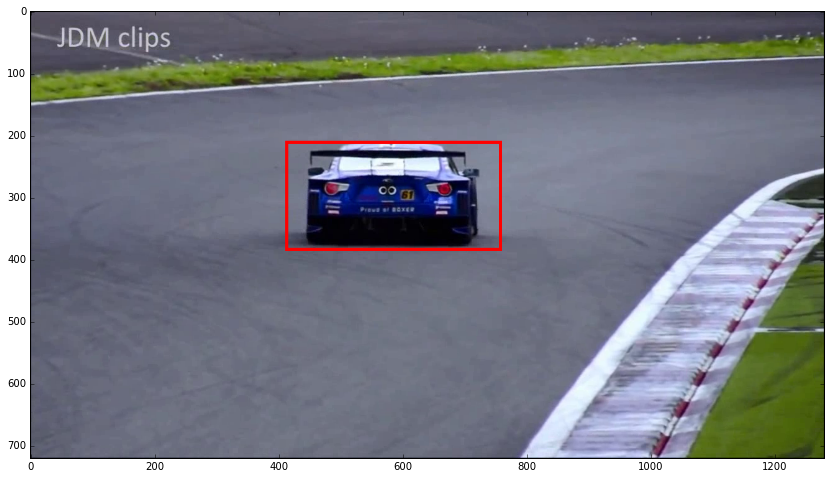

In [54]:
plt.figure(figsize=(16, 8))
plt.imshow(im)